In [1]:
%pylab inline
import pandas as pd
from scipy.stats import pearsonr
from pycorrelate.pycorrelate import ucorrelate
from scipy import stats 
from scipy.ndimage import gaussian_filter

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def autocorr(x,maxlag):
    srate=0.002 # 2 ms,used to convert spike co-occurence in rate 
    result = ucorrelate(x,x,maxlag+1) #+1 used to have a vector of lenght maxlag after 0 removal
    return result[1:]*srate #removes 0 

def SNR(st): #takes as argument the spike train at a 2ms resolution
    maxlag=500 # up to 1000 ms
    c=autocorr(st,maxlag) 
    ps=(np.abs(np.fft.rfft(c-mean(c)))**2) #calculates power spectrum
    noise=mean(ps[:125])
    minbin=5 #from 5 Hz
    maxbin=10 # to 10 Hz
    peak=argmax(ps[minbin:maxbin])+minbin
    signal=mean(ps[peak-1:peak+1]) #1Hz on each size of the peak
    SNR=signal/noise
    return SNR

# Scoring

In [ ]:
#cells data
st=np.load("CellData/spikeTrain2ms.npy")
rate=np.load("CellData/firingRateRaw.npy")
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)

#CALCULATES SNR
SNRS=np.zeros(len(st))
for i in range(len(st)):
    if cellMetadata["include"].values[i]==1:
        SNRS[i]=SNR(st[i])
    else:
        SNRS[i]=np.nan
    if i%10==0:
        print("Done cell:"+str(i+1))
ellMetadata["thetaModulationScore"]=SNRS

In [ ]:
thetaModulated=np.zeros(len(SNRS))
for i in range(len(SNRS)):
    if SNRS[i]>5:
        thetaModulated[i]=1
        
cellMetadata["thetaModulated"]=thetaModulated

In [ ]:
cellMetadata.to_csv("CellData/metadata.csv")

# Plots

In [7]:
#cells data
st=np.load("CellData/spikeTrain2ms.npy")
st=pd.DataFrame(st.T,columns=cellMetadata.index)

angularVelocity=pd.read_csv("TrialData/filteredAngularVelocity.csv")
speed=pd.read_csv("TrialData/filteredSpeed.csv")

trialMetadata=pd.read_csv("TrialData/metadata.csv",index_col=0)
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)

rate=pd.read_csv("CellData/firingRate.csv")

angularVelocity.columns=trialMetadata["trialIndex"].values
speed.columns=trialMetadata["trialIndex"].values


## Speed

## Theta

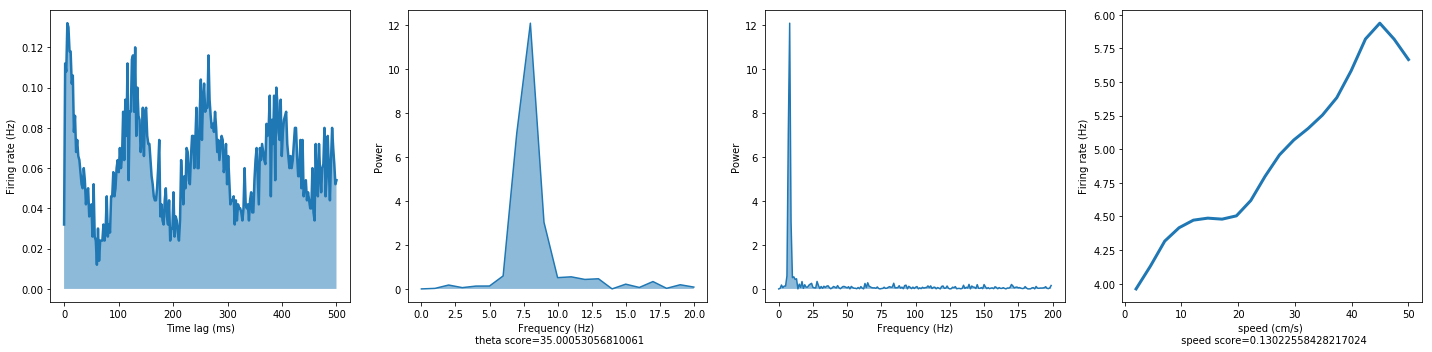

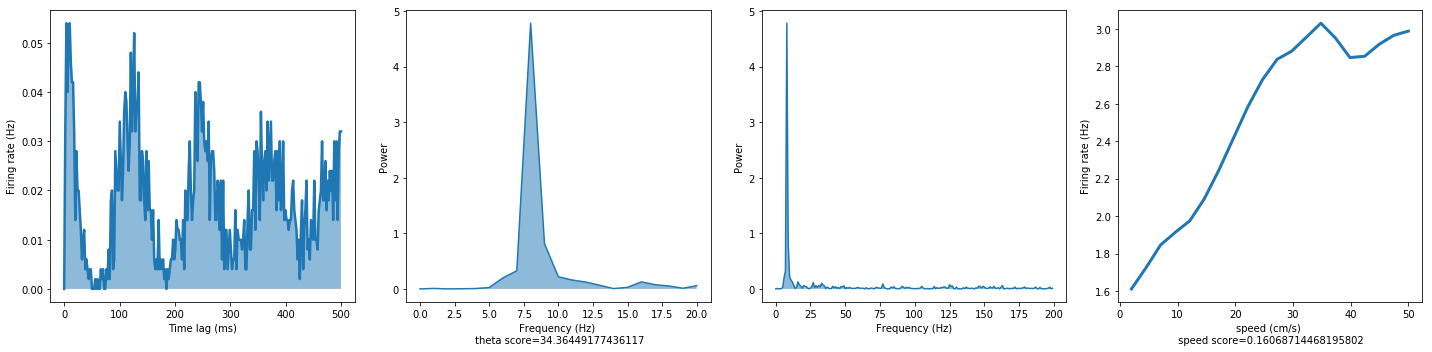

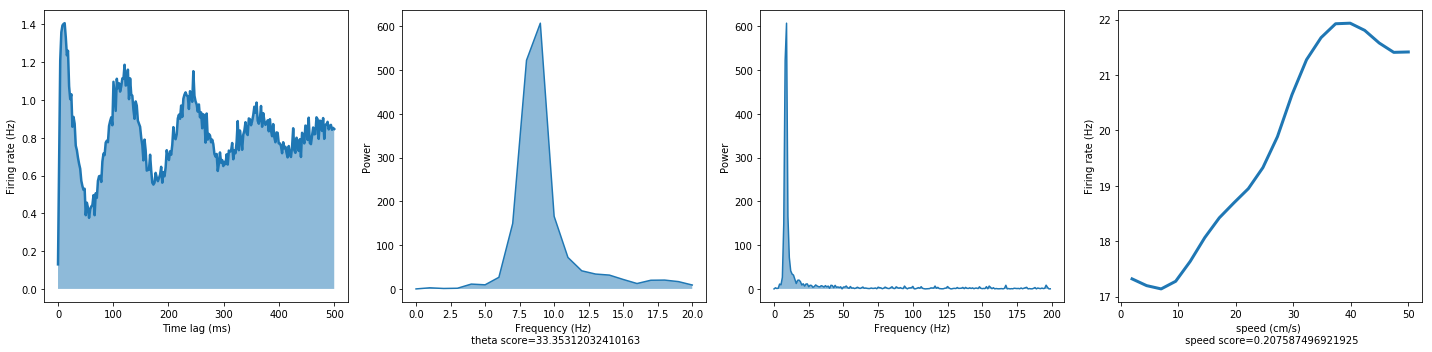

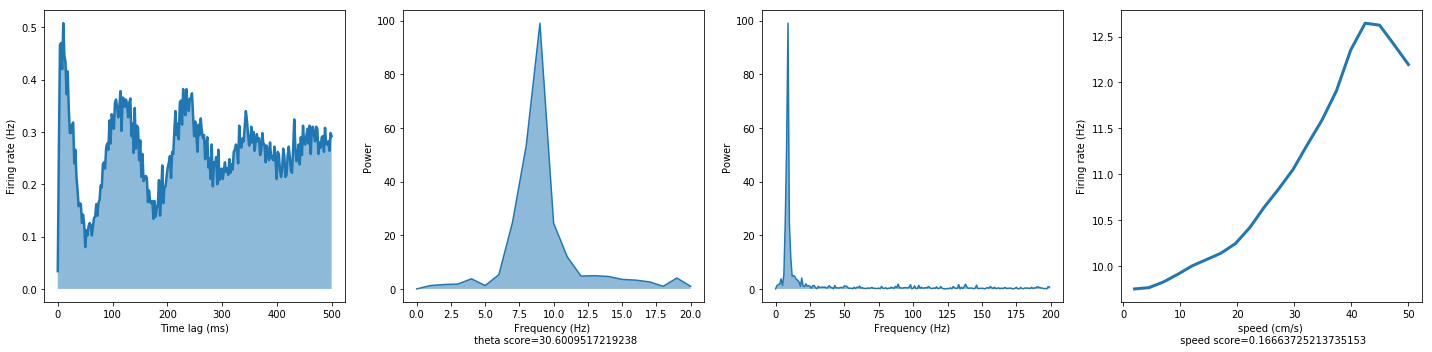

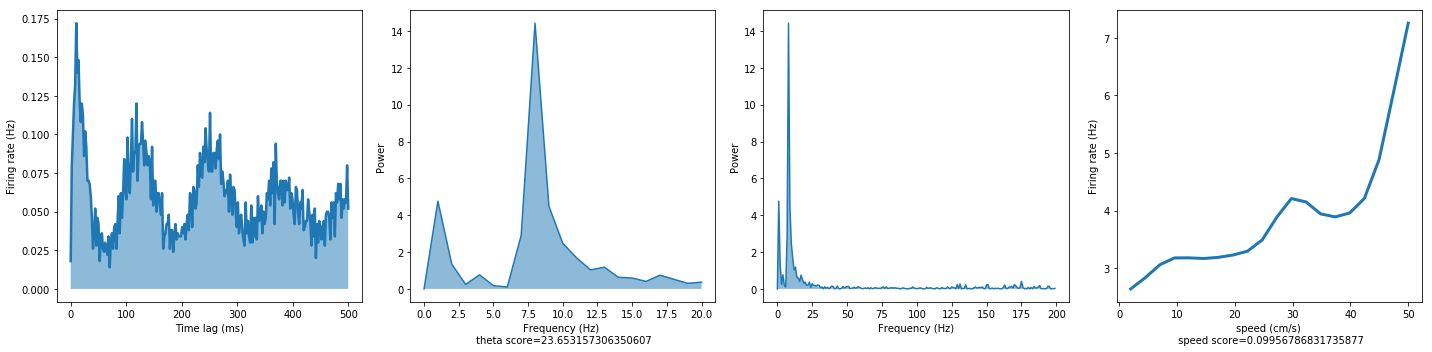

In [10]:
#BY REGION
region="PaS"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["speedModulated"]==1].sort_values("thetaModulationScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=speed[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n speed score="+str(thetaModulationScoreSorted["speedScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_Theta_speed_example_cell"+str(cell+1)+".svg")

## NO THETA

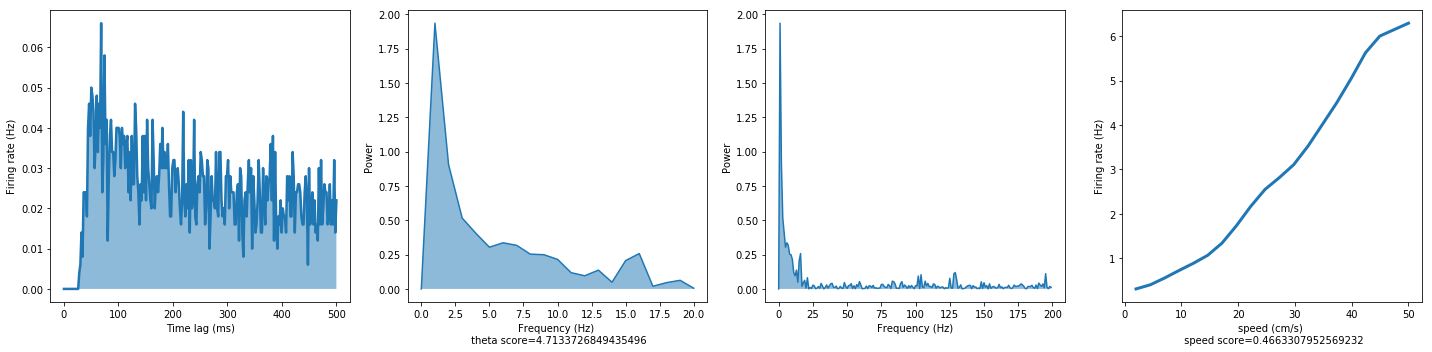

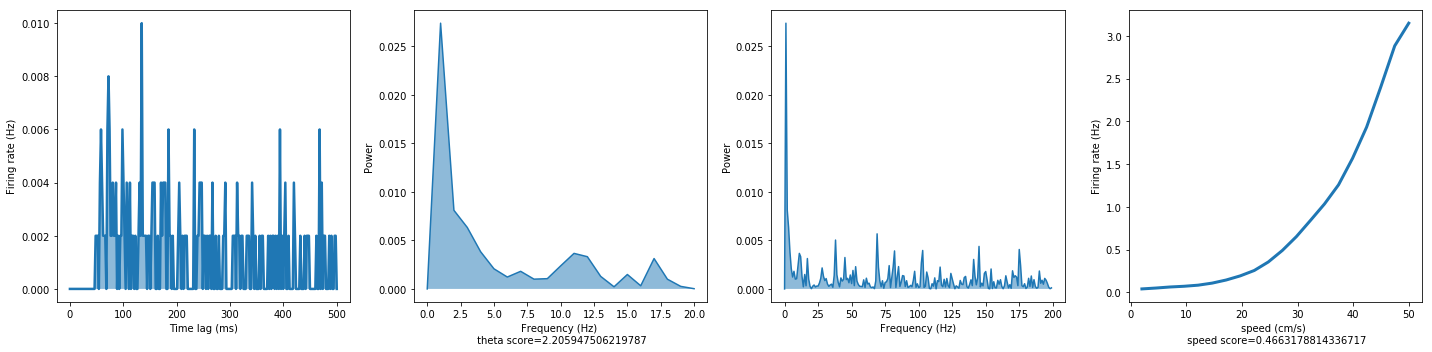

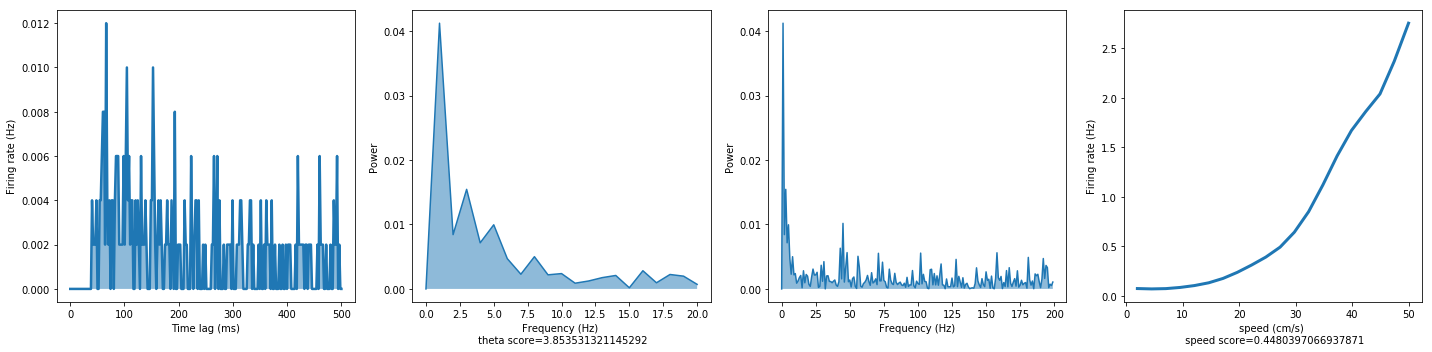

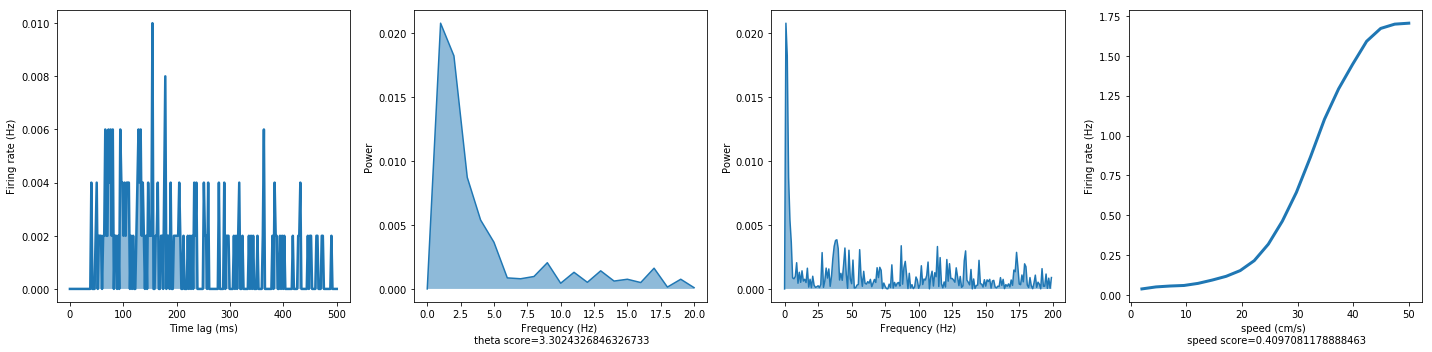

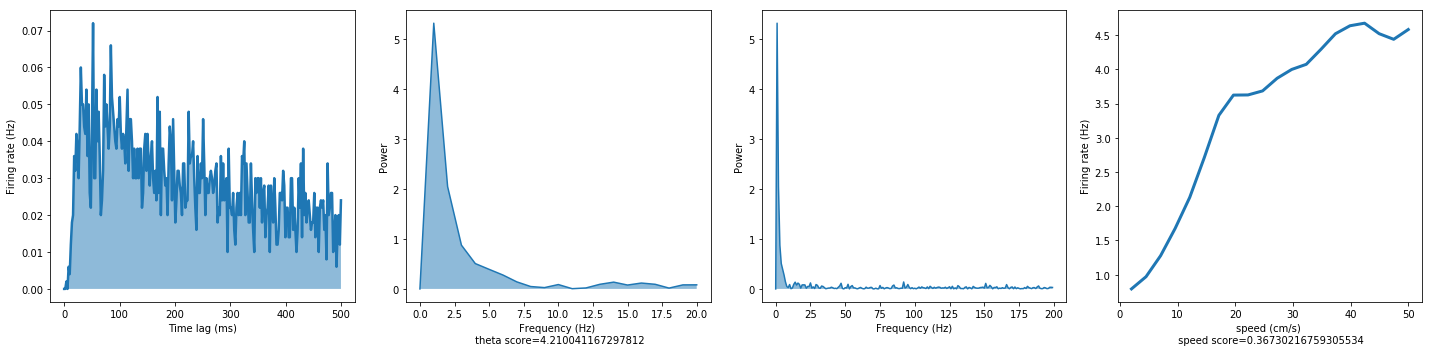

In [13]:
#BY REGION, NO THETA
region="PrS"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["thetaModulated"]==0].sort_values("speedScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=speed[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n speed score="+str(thetaModulationScoreSorted["speedScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_NOTheta_speed_example_cell"+str(cell+1)+".svg")

# AV CW

## THETA

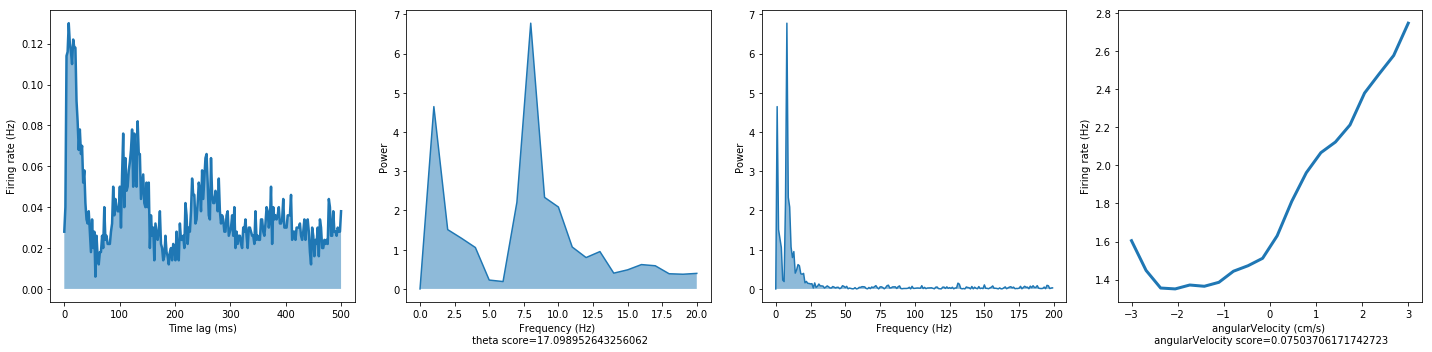

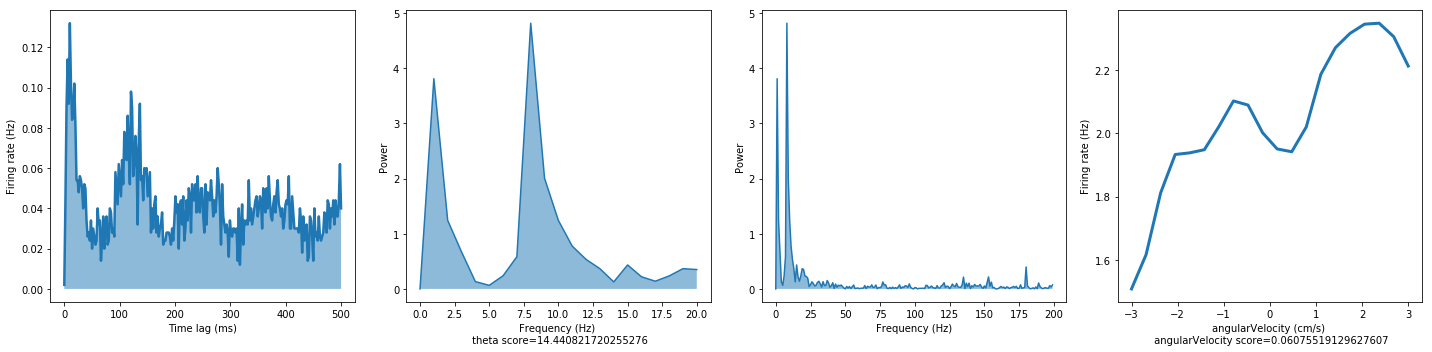

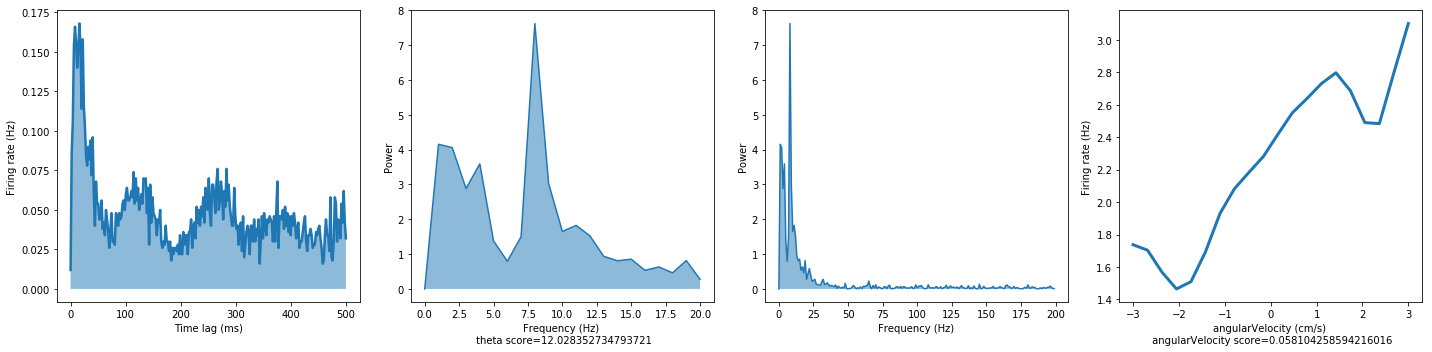

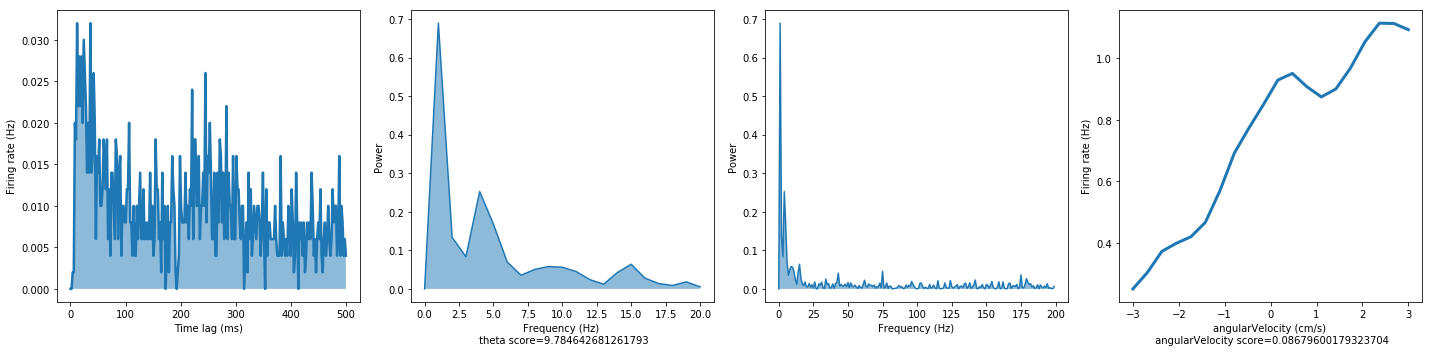

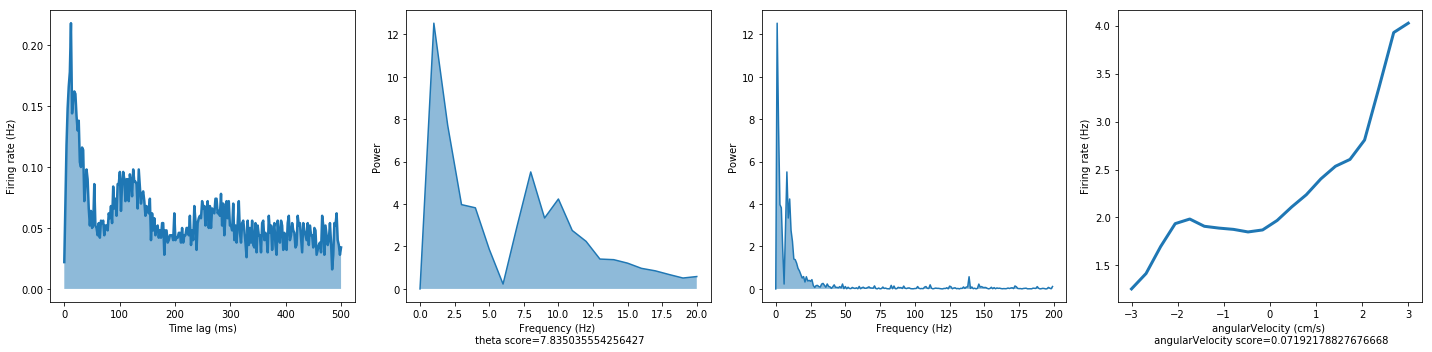

In [16]:
#BY REGION
region="PrS"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["angularVelocityModulated"]==1].sort_values("thetaModulationScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_Theta_angularVelocityCW_example_cell"+str(cell+1)+".svg")

## NO THETA

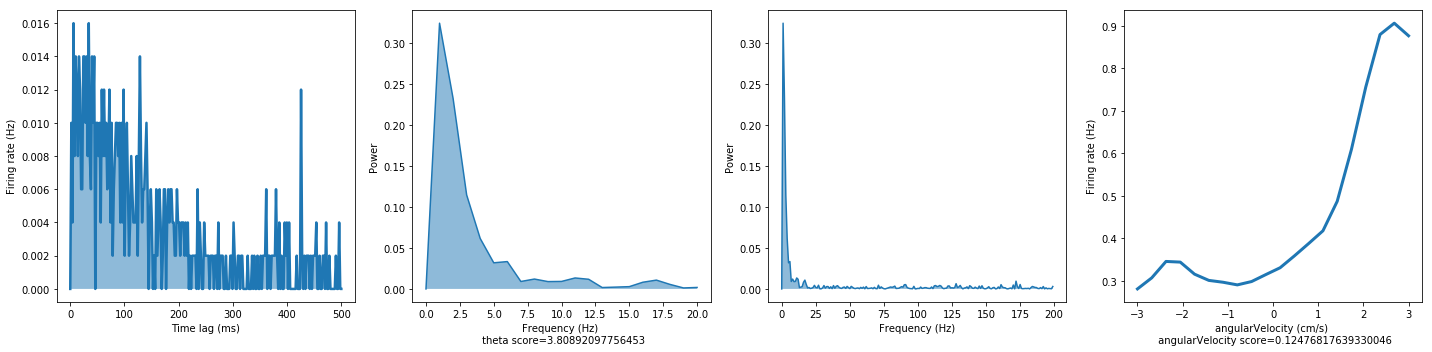

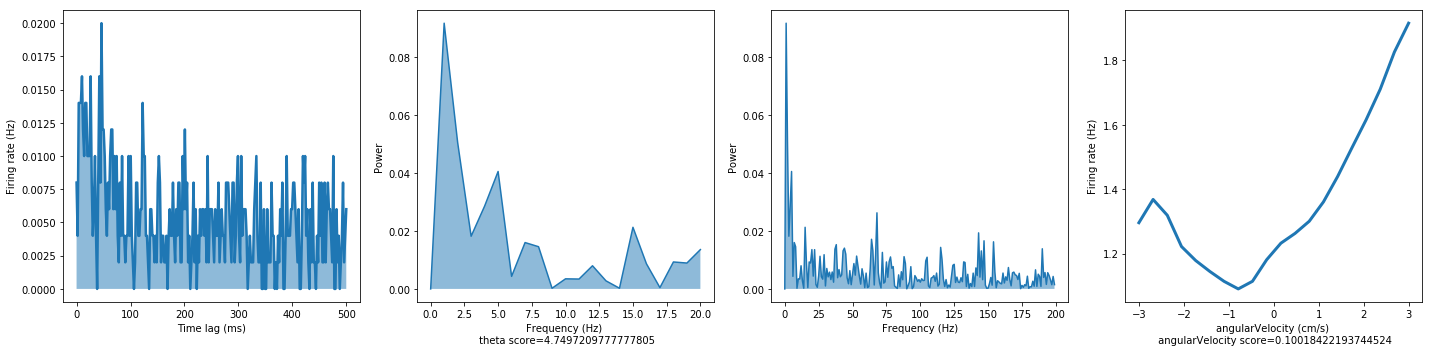

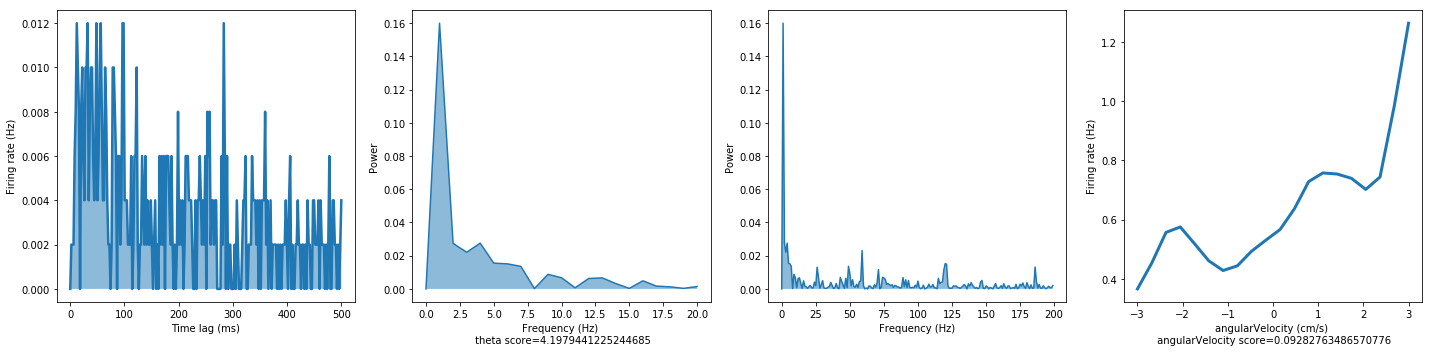

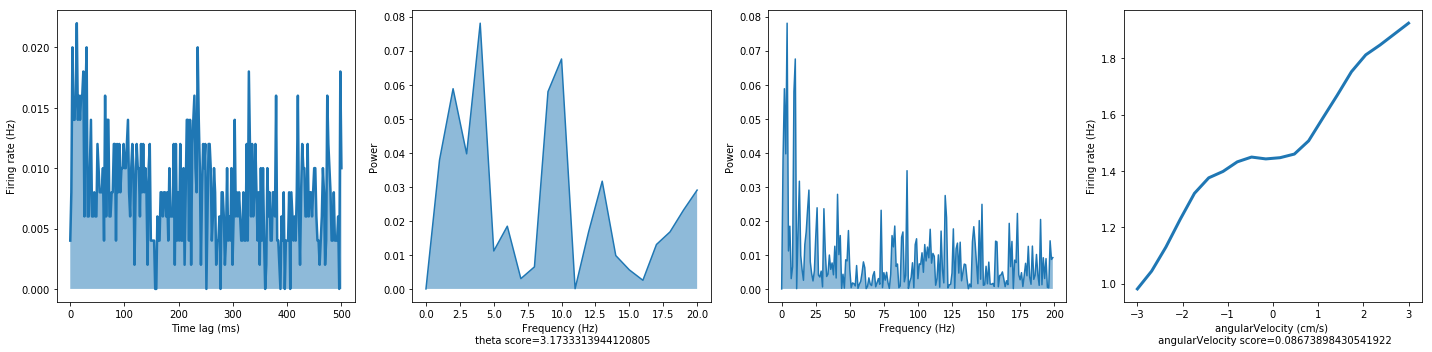

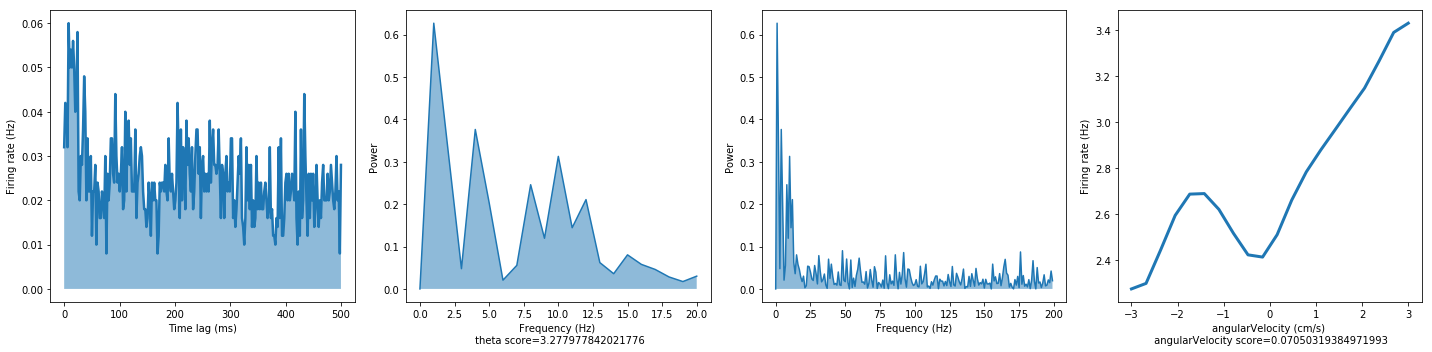

In [20]:
#BY REGION
region="MEC"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["thetaModulated"]==0].sort_values("angularVelocityScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_NOTheta_angularVelocityCW_example_cell"+str(cell+1)+".svg")

# AV CCW

## THETA

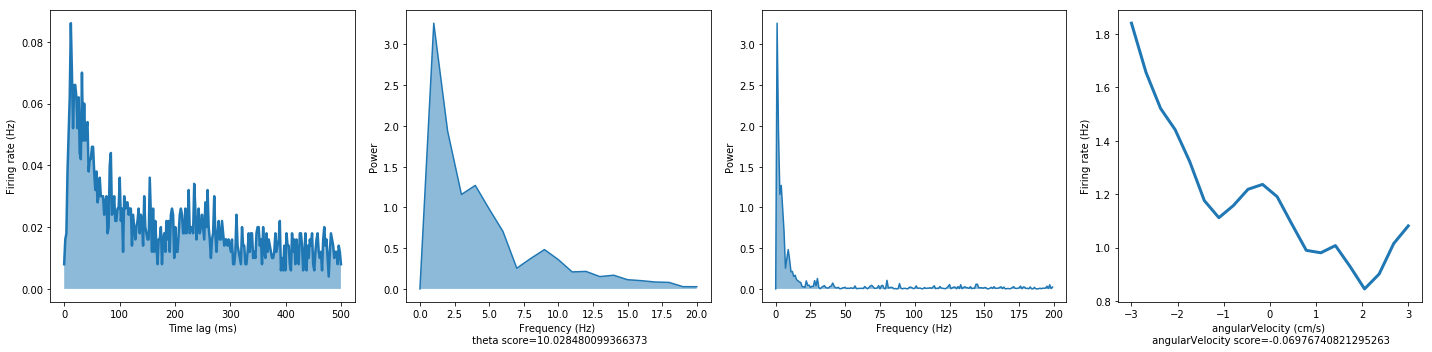

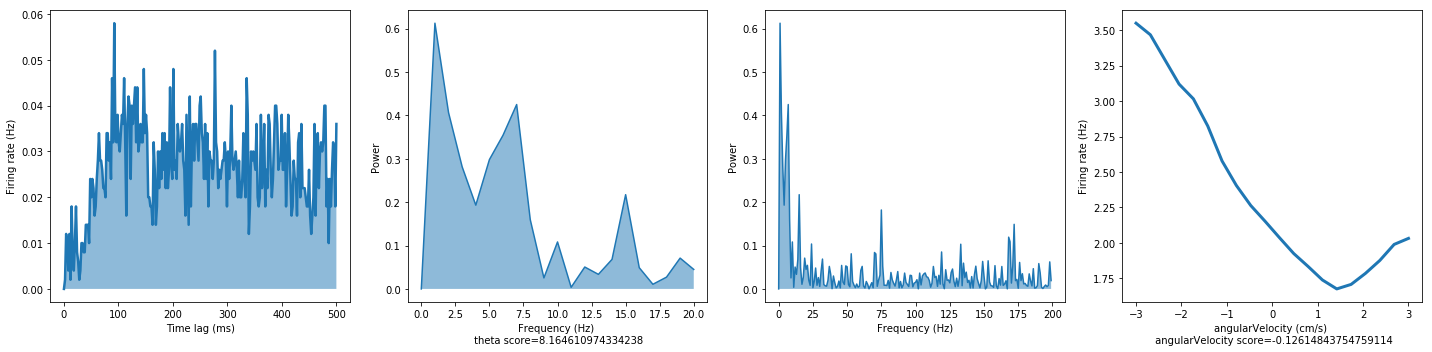

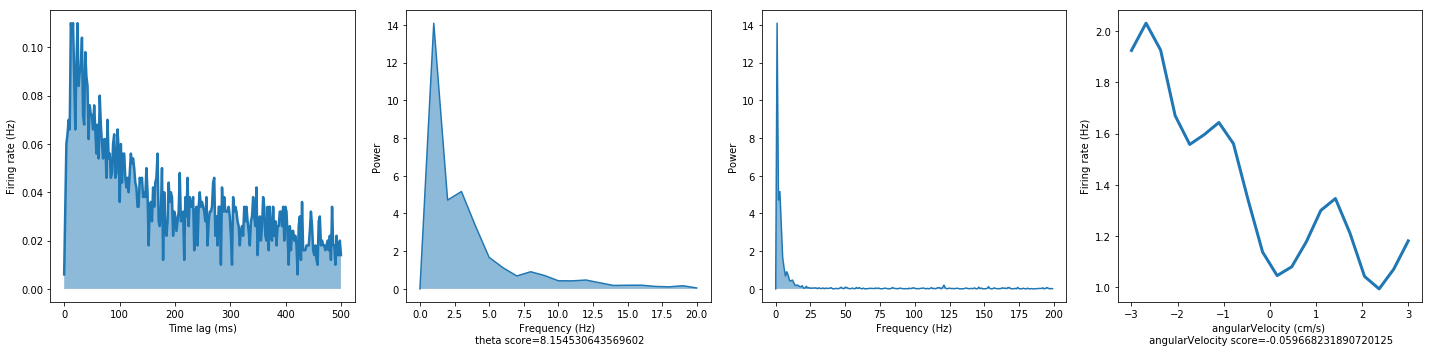

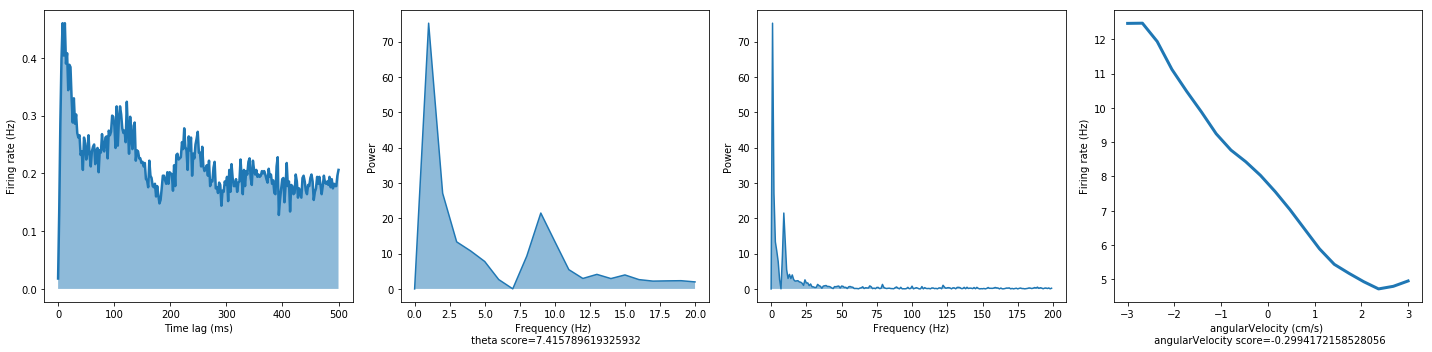

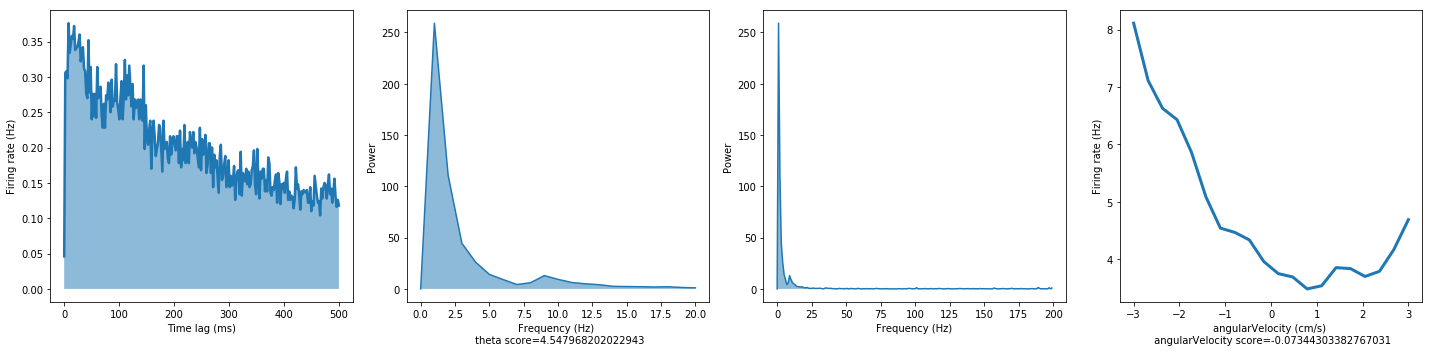

In [23]:
#BY REGION
region="MEC"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["angularVelocityCCWModulated"]==1].sort_values("thetaModulationScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_Theta_angularVelocityCCW_example_cell"+str(cell+1)+".svg")

## NO THETA

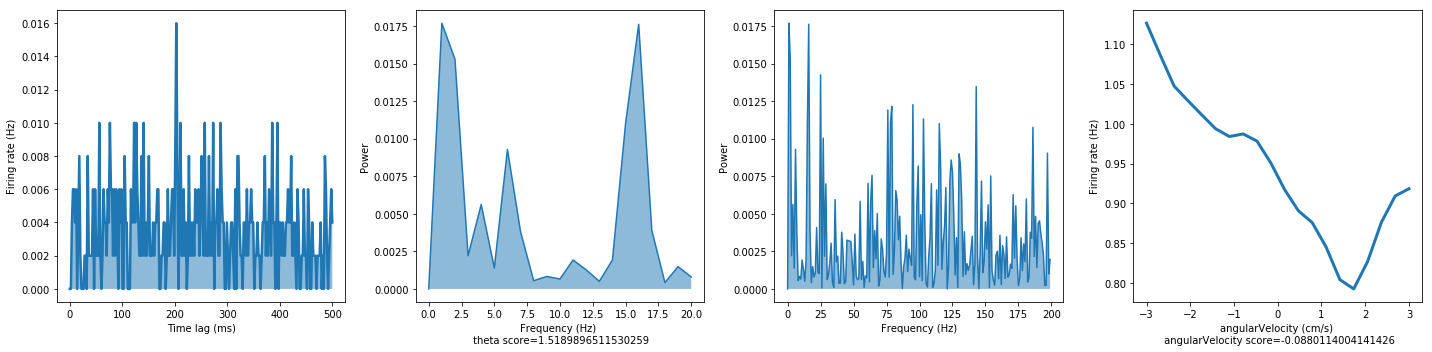

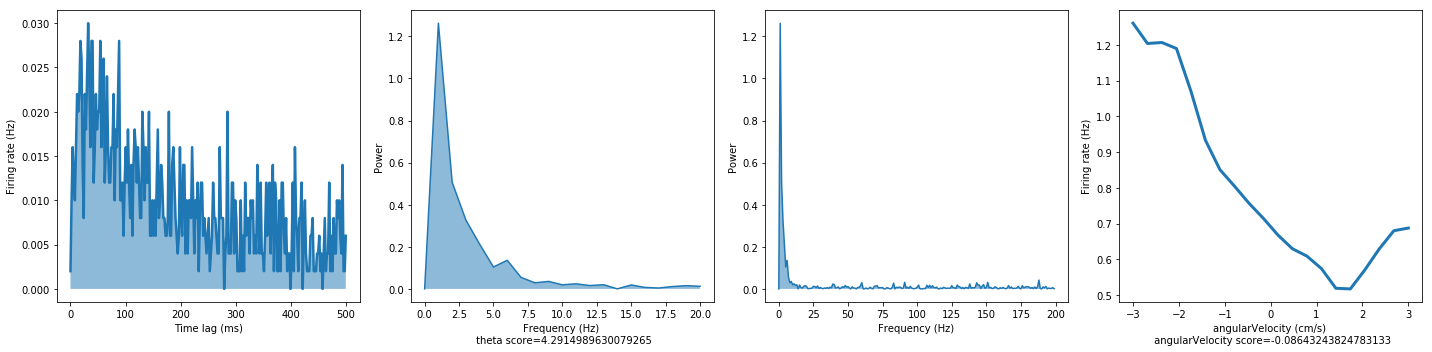

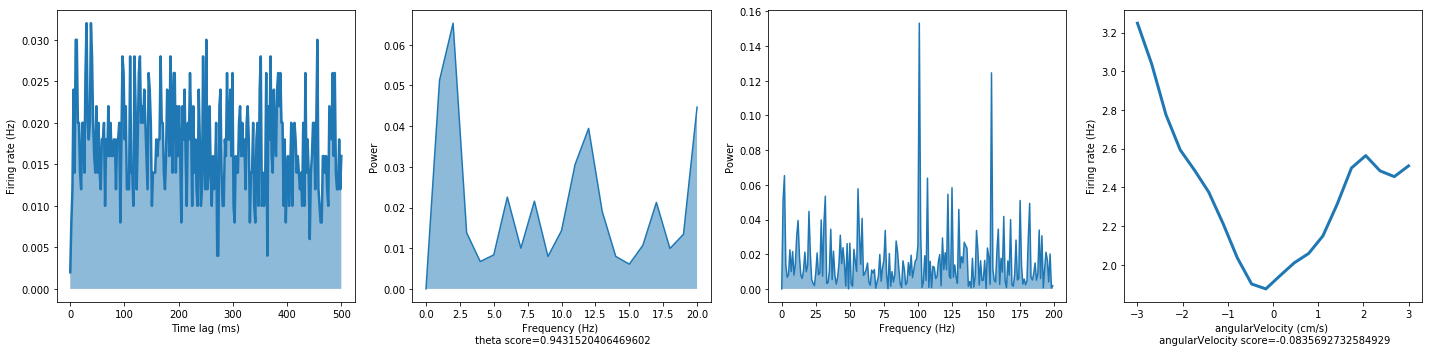

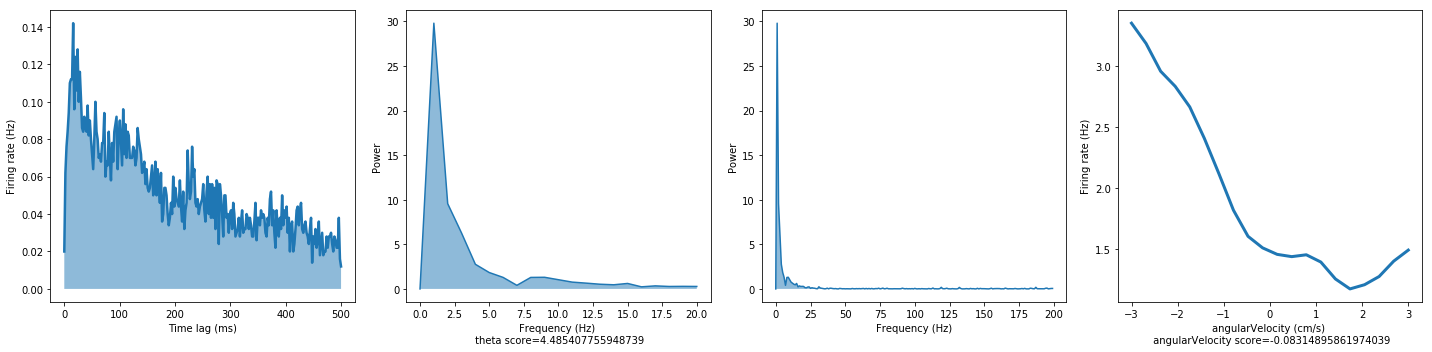

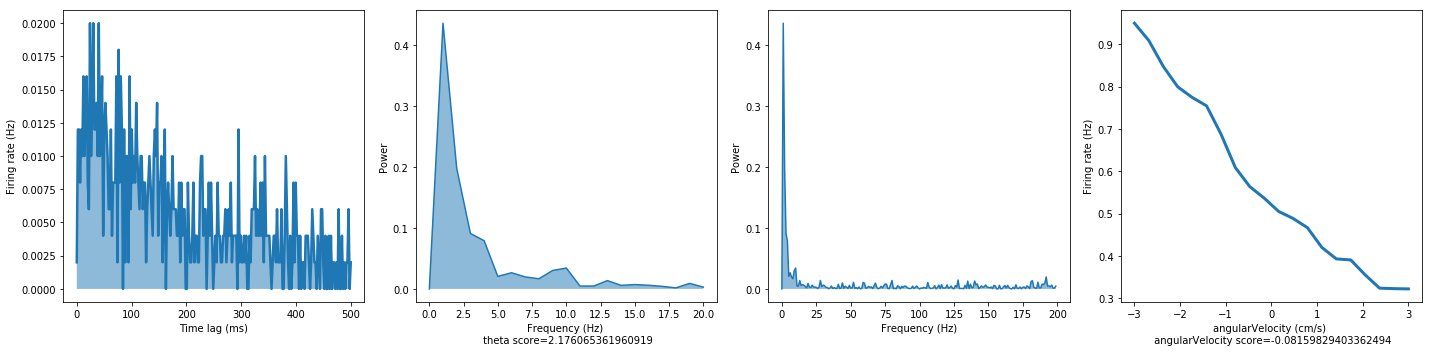

In [26]:
#BY REGION
region="PrS"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["thetaModulated"]==0].sort_values("angularVelocityScore",ascending=True)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_NOTheta_angularVelocityCCW_example_cell"+str(cell+1)+".svg")

# AV ABS

## THETA

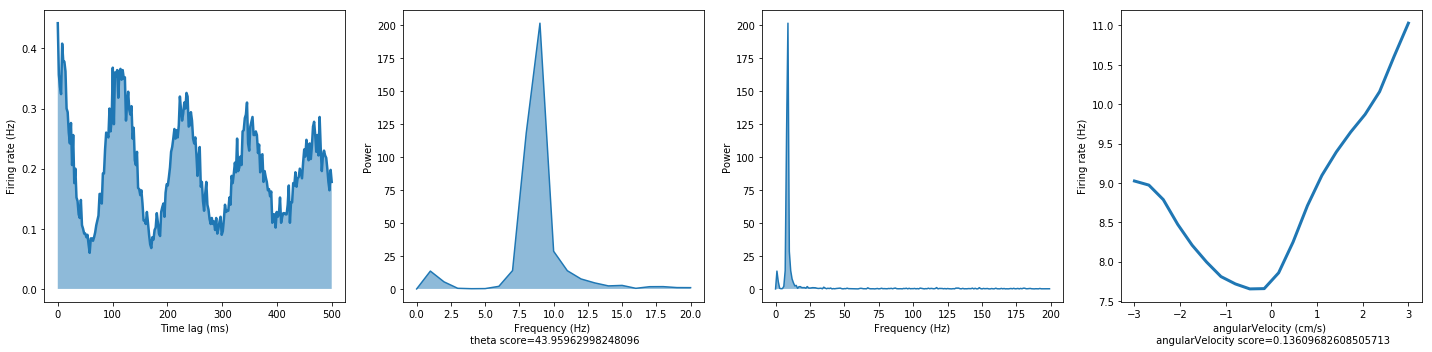

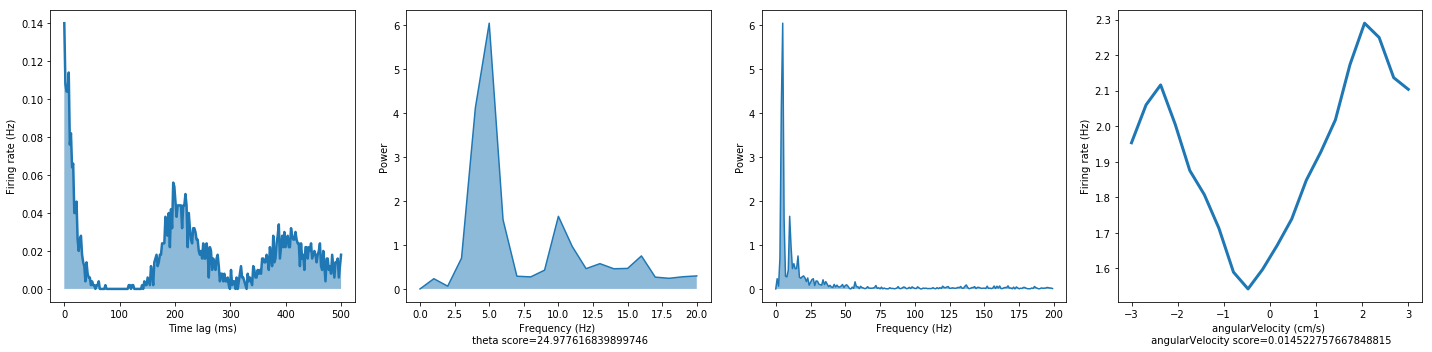

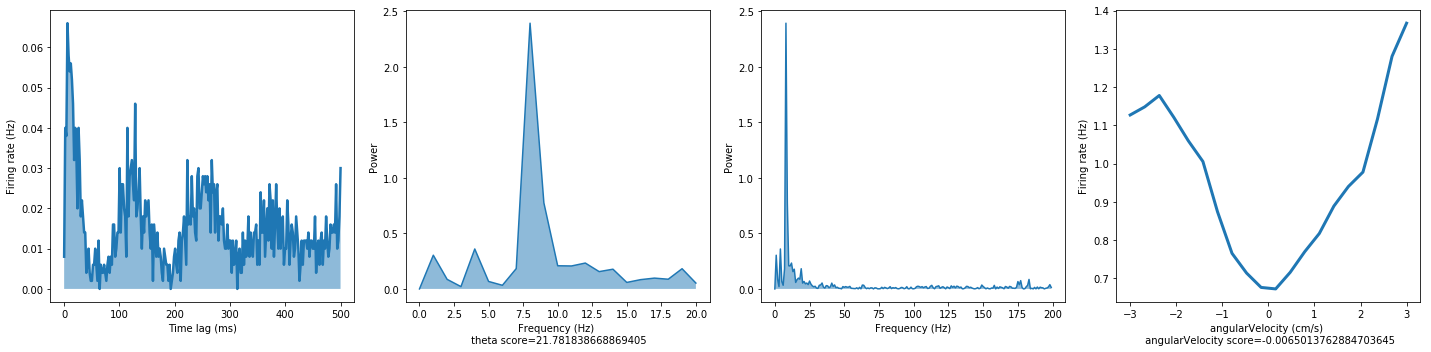

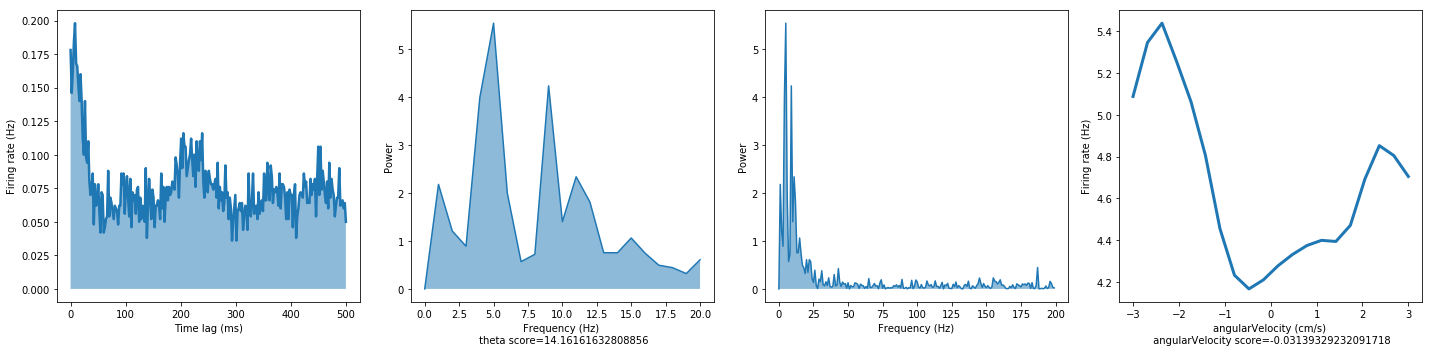

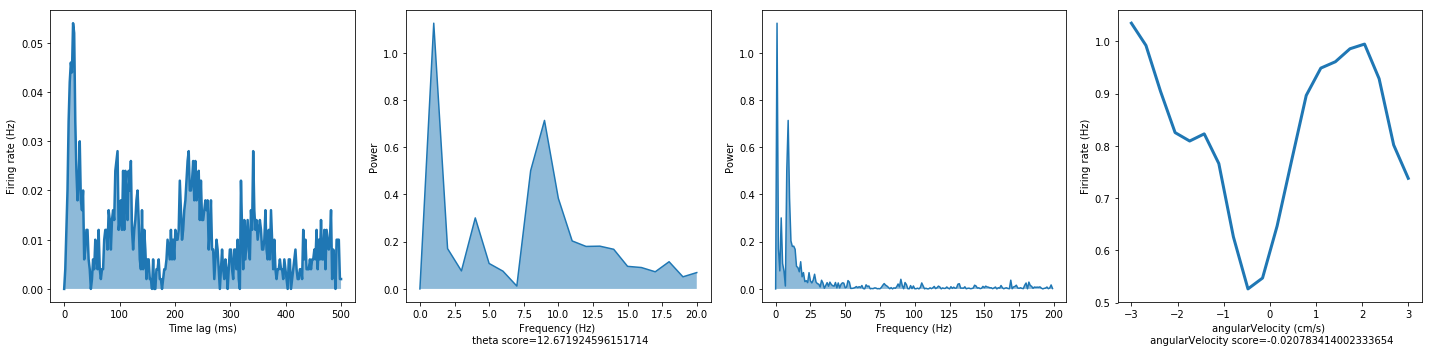

In [29]:
#BY REGION
region="MEC"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["absAngularVelocityModulated"]==1].sort_values("thetaModulationScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_Theta_angularVelocityABS_example_cell"+str(cell+1)+".svg")

## NO THETA

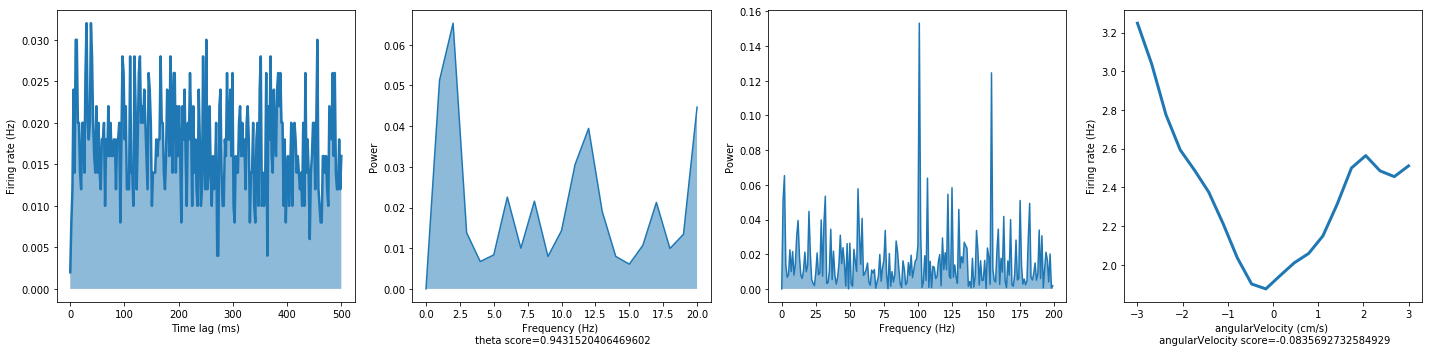

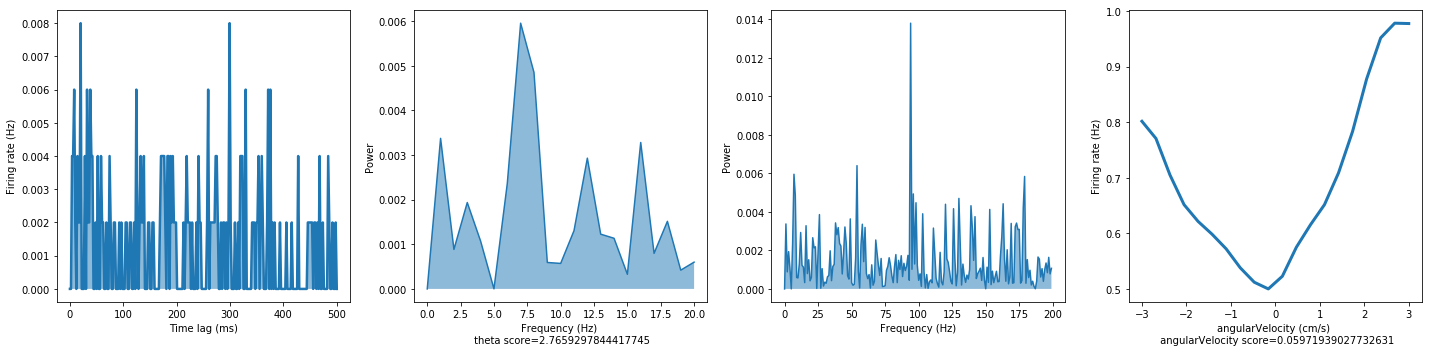

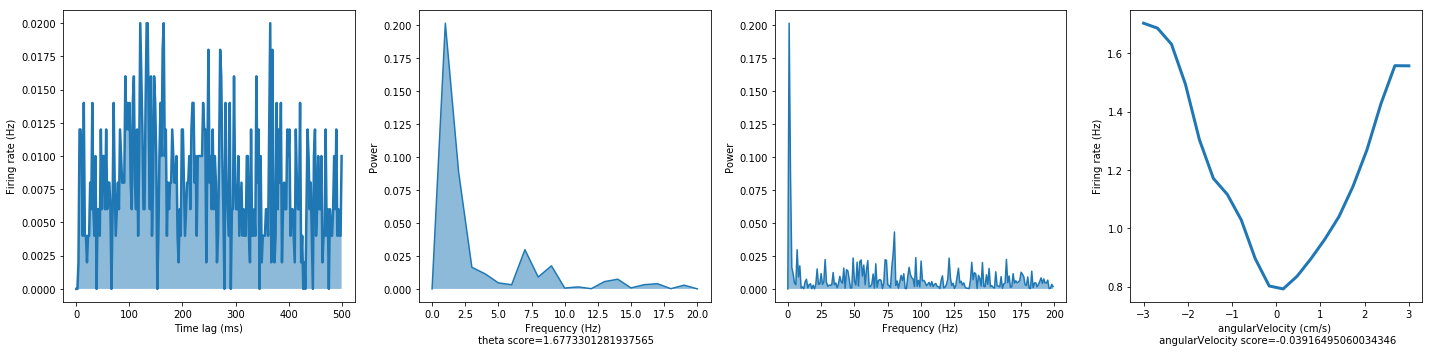

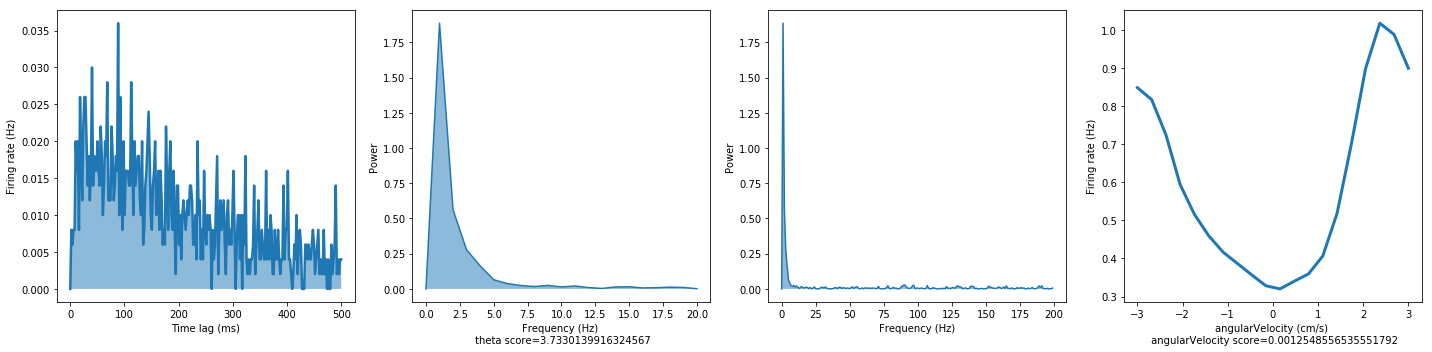

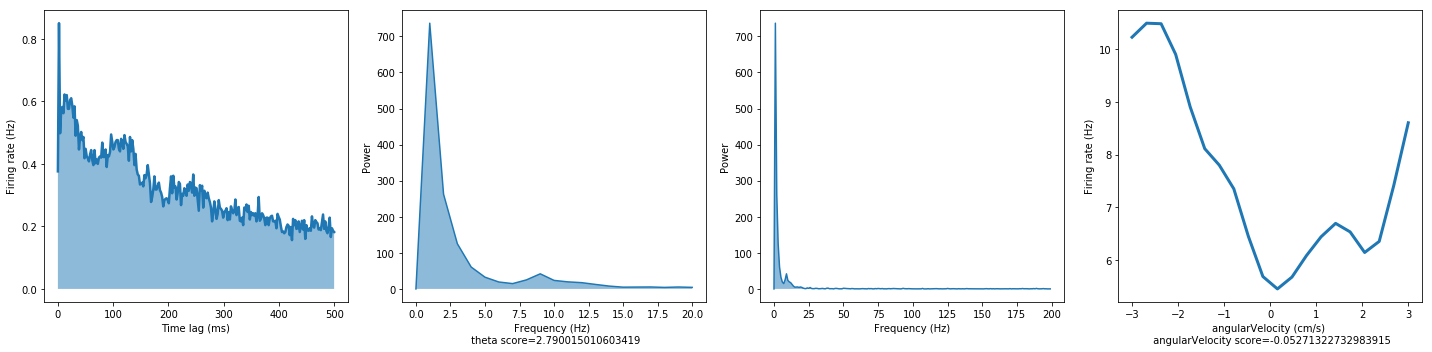

In [32]:
#BY REGION
region="PrS"
PRScells=cellMetadata[cellMetadata["region"]==region]
thetaModulationScoreSorted=PRScells[PRScells["thetaModulated"]==0].sort_values("absAngularVelocityScore",ascending=False)
#EXAMPLE PLOTTING 
for cell in range(5):
    figure(figsize(20,5))
    subplot(1,4,1)
    strain=st[thetaModulationScoreSorted.index[cell]].values
    x=linspace(0,500,250)
    y=autocorr(strain,250)
    plot(x,y,linewidth=2.5)
    fill_between(x, 0, y,alpha=0.5)
    xlabel("Time lag (ms)")
    ylabel("Firing rate (Hz)")
    subplot(1,4,2)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:21], ps[:21])
    xlabel("Frequency (Hz) \n theta score="+str(thetaModulationScoreSorted["thetaModulationScore"].values[cell]))
    ylabel("Power")
    fill_between(freqs[:21], 0, ps[:21],alpha=0.5)
    subplot(1,4,3)
    y=autocorr(strain,500)
    ps = np.abs(np.fft.rfft(y-mean(y)))**2
    time_step = 0.002
    freqs = np.fft.rfftfreq(y.size, time_step)
    plt.plot(freqs[:200], ps[:200])
    xlabel("Frequency (Hz)")
    ylabel("Power")
    fill_between(freqs[:200], 0, ps[:200],alpha=0.5)
    ax=subplot(1,4,4)
    r=rate[thetaModulationScoreSorted.index[cell]].values
    s=angularVelocity[thetaModulationScoreSorted["trialIndex"][cell]].values
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[-3,3])[0]
    y1=gaussian_filter(y,1)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n angularVelocity score="+str(thetaModulationScoreSorted["angularVelocityScore"][cell]))
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig(region+"_NOTheta_angularVelocityABS_example_cell"+str(cell+1)+".svg")

# CORRELATIONS

In [2]:
%pylab inline
import pandas as pd
from scipy.stats import pearsonr
from pycorrelate.pycorrelate import ucorrelate
from scipy import stats 
from scipy.ndimage import gaussian_filter

Populating the interactive namespace from numpy and matplotlib


In [3]:
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)

## Speed

[-0.4, 0.4, -0.5, 50]

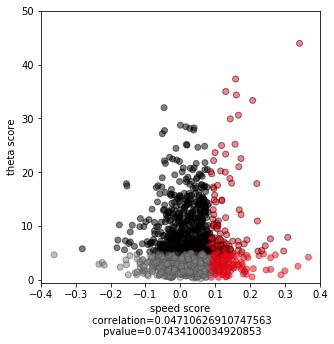

In [27]:
fcolors=[]
ecolors=[]
included=cellMetadata[(cellMetadata["include"]==1)]
for i in included.index:
    cell=included.loc[i]
    if cell["speedModulated"]==0 and cell["thetaModulated"]==0 :
        fcolors.append("grey")
        ecolors.append("#515151")
    if cell["speedModulated"]==1  and cell["thetaModulated"]==0:
        fcolors.append("#ff0310")
        ecolors.append("#af1722")
    if cell["speedModulated"]==0 and cell["thetaModulated"]==1:
        fcolors.append("k")
        ecolors.append("k")
    if cell["speedModulated"]==1  and cell["thetaModulated"]==1:
        fcolors.append("#ff0310")
        ecolors.append("k")
figure(figsize=(5,5))
x=included["speedScore"].values
y=included["thetaModulationScore"].values
scatter(x,y,facecolors=fcolors,edgecolors=ecolors,alpha=0.5)
#axvline(x=cellMEC["angularVelocityTh"].values[0],linestyle='--',c='k')
#axhline(y=5,linestyle='--')
ylabel("theta score")
xlabel("speed score\n correlation="+str(pearsonr(x,y)[0])+"\n pvalue="+str(pearsonr(x,y)[1]))
axis([-0.4,0.4,-0.5,50])
savefig("2Dplot_correlation_THETA_Speed.svg")

## AHV unidir

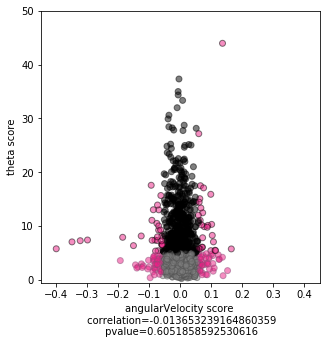

In [18]:
#CORRELATION BETWEEN aangularVelocity SCORE AND theta SCORE
fcolors=[]
ecolors=[]
included=cellMetadata[(cellMetadata["include"]==1)]
for i in included.index:
    cell=included.loc[i]
    if cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0 and cell["thetaModulated"]==0 :
        fcolors.append("grey")
        ecolors.append("#515151")
    if cell["angularVelocityModulated"]==1  and cell["thetaModulated"]==0:
        fcolors.append("#ec1f85")
        ecolors.append("#8e4c77")
    if cell["angularVelocityCCWModulated"]==1  and cell["thetaModulated"]==0:
        fcolors.append("#ec1f85")
        ecolors.append("#8e4c77")
    if cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0 and cell["thetaModulated"]==1:
        fcolors.append("k")
        ecolors.append("k")
    if cell["angularVelocityModulated"]==1  and cell["thetaModulated"]==1:
        fcolors.append("#ec1f85")
        ecolors.append("k")
    if cell["angularVelocityCCWModulated"]==1  and cell["thetaModulated"]==1:
        fcolors.append("#ec1f85")
        ecolors.append("k")
figure(figsize=(5,5))
x=included["angularVelocityScore"].values
y=included["thetaModulationScore"].values
scatter(x,y,facecolors=fcolors,edgecolors=ecolors,alpha=0.5)
#axvline(x=cellMEC["angularVelocityTh"].values[0],linestyle='--',c='k')
#axhline(y=5,linestyle='--')
xlabel("angularVelocity score \n correlation="+str(pearsonr(x,y)[0])+"\n pvalue="+str(pearsonr(x,y)[1]))
ylabel("theta score")
axis([-0.45,0.45,-0.5,50])
savefig("2Dplot_correlation_THETA_AngularVelocity.svg")

## AHV bidir

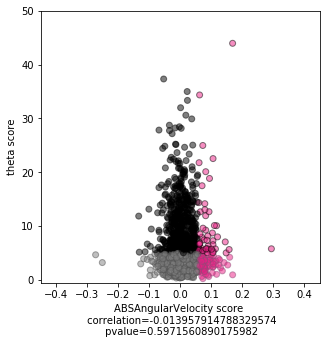

In [22]:
fcolors=[]
ecolors=[]
included=cellMetadata[(cellMetadata["include"]==1)]
for i in included.index:
    cell=included.loc[i]
    if cell["absAngularVelocityModulated"]==0 and cell["thetaModulated"]==0 :
        fcolors.append("grey")
        ecolors.append("#515151")
    if cell["absAngularVelocityModulated"]==1  and cell["thetaModulated"]==0:
        fcolors.append("#ec1f85")
        ecolors.append("#8e4c77")
    if cell["absAngularVelocityModulated"]==0 and cell["thetaModulated"]==1:
        fcolors.append("k")
        ecolors.append("k")
    if cell["absAngularVelocityModulated"]==1  and cell["thetaModulated"]==1:
        fcolors.append("#ec1f85")
        ecolors.append("k")
figure(figsize=(5,5))
x=included["absAngularVelocityScore"].values
y=included["thetaModulationScore"].values
scatter(x,y,facecolors=fcolors,edgecolors=ecolors,alpha=0.5)
#axvline(x=cellMEC["angularVelocityTh"].values[0],linestyle='--',c='k')
#axhline(y=5,linestyle='--')
xlabel("ABSAngularVelocity score \n correlation="+str(pearsonr(x,y)[0])+"\n pvalue="+str(pearsonr(x,y)[1]))
ylabel("theta score")
axis([-0.45,0.45,-0.5,50])
savefig("2Dplot_correlation_THETA_ABSAngularVelocity.svg")